## Plot distribution of standardized residuals

GARCH models make distribution assumptions of the standardized residuals. Recall residuals are the differences between predicted returns and the mean returns. And standardized residuals are the residuals divided by the model estimated volatility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from pandas_datareader import DataReader
from datetime import datetime

In [2]:
start = datetime(2010,1,1)
end = datetime(2020,7,10)

sp_price = DataReader('^GSPC', 'yahoo',start, end)
sp_price.drop(columns=['High','Low','Open','Volume','Adj Close'], inplace=True)
sp_price['Return'] = 100*(sp_price['Close'].pct_change())

In [3]:
np.random.seed(4)
normal_resid = np.random.normal(size = sp_price.shape[0])
normal_vol = normal_resid.std()

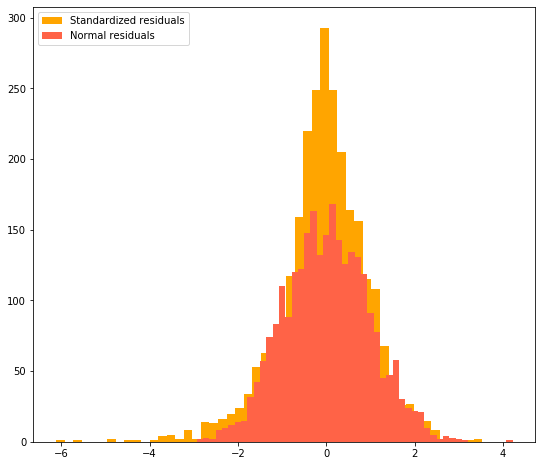

In [4]:
# Specify a GARCH(1,1) model
basic_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, 
                      mean = 'constant', vol = 'GARCH', dist = 't')
# Fit the model
gm_result = basic_gm.fit(disp = 'off')

# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 50, 
         facecolor = 'orange', label = 'Standardized residuals')
plt.hist(normal_resid, bins = 50, 
         facecolor = 'tomato', label = 'Normal residuals')
plt.legend(loc = 'upper left')
plt.show()

Compared with a standard normal distribution, the distribution curve of standardized residuals from the GARCH models exhibits more peaks, asymmetry, and has a negative skew

## Fit a GARCH with skewed t-distribution

The default normal distribution assumption of the standardized residuals used in GARCH models are not representative of the real financial world. Fat tails and skewness are frequently observed in financial return data.

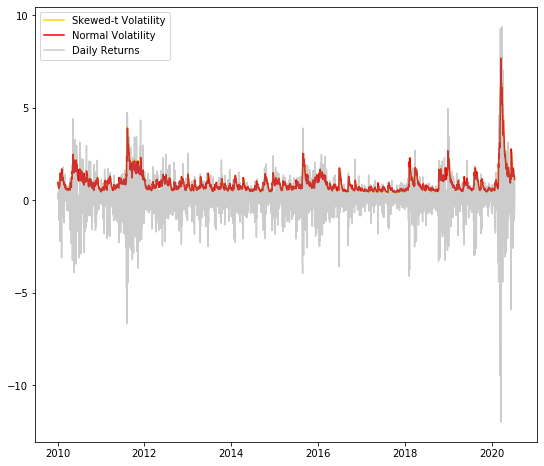

In [5]:
# Specify a GARCH(1,1) model
normal_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, 
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

# Fit the model
normal_result = normal_gm.fit(disp = 'off')

# Get model estimated volatility
normal_vol = normal_result.conditional_volatility

# Specify GARCH model assumptions
skewt_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, 
                      mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

# Plot model fitting results
plt.plot(skewt_vol, color = 'gold', label = 'Skewed-t Volatility')
plt.plot(normal_vol, color = 'red', label = 'Normal Volatility')
plt.plot(sp_price['Return'], color = 'grey',label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper left')
plt.show()

With skewed Student’s t-distribution assumption, GARCH model estimation is more in line with the actual observations.

## Effect of mean model on volatility predictions

In practice, returns and volatility are modeled in separate processes. Typically the mean assumptions influence predicted returns, but have a minor effect on the volatility estimations.

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -3283.22
Distribution:                  Normal   AIC:                           6574.43
Method:            Maximum Likelihood   BIC:                           6597.96
                                        No. Observations:                 2647
Date:                Mon, Jul 13 2020   Df Residuals:                     2643
Time:                        08:32:28   Df Model:                            4
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0830  1.390e-02      5.970  2.376e-09 [5.572e-0

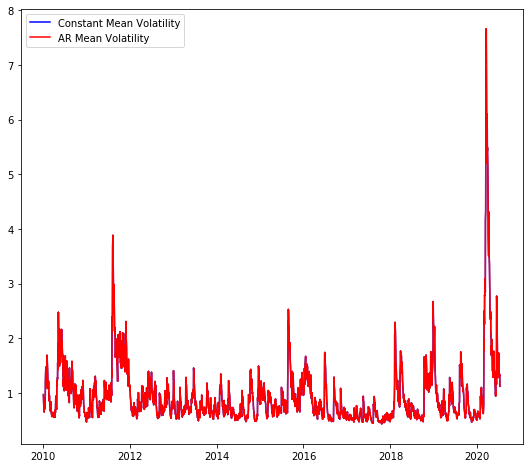

1.0


In [6]:
# Specify a GARCH(1,1) model
cmean_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, 
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

# Fit the model
cmean_result = cmean_gm.fit(disp = 'off')

# Get model estimated volatility
cmean_vol = cmean_result.conditional_volatility

# Specify a GARCH(1,1) model
armean_gm = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, 
                      mean = 'AR', vol = 'GARCH', dist = 'normal')

# Fit the model
armean_result = armean_gm.fit(disp = 'off')

# Get model estimated volatility
armean_vol = armean_result.conditional_volatility

# Print model summary of GARCH with constant mean
print(cmean_result.summary())
# Print model summary of GARCH with AR mean
print(armean_result.summary())

# Plot model volatility 
plt.plot(cmean_vol, color = 'blue', label = 'Constant Mean Volatility')
plt.plot(armean_vol, color = 'red', label = 'AR Mean Volatility')
plt.legend(loc = 'upper left')
plt.show()

# Check correlation of volatility estimations
print(np.corrcoef(cmean_vol, armean_vol)[0,1])

The correlation coefficient is 1, and the plot shows volatility estimation from both models are very close. In fact, the impact of the mean model assumptions on volatility estimation is so small that, if the interest is only in the volatility dynamics, usually one can just assume the most simple specification, namely the constant mean model.

## Fit GARCH models to cryptocurrency

Financial markets tend to react to positive and negative news shocks very differently, and one example is the dramatic swings observed in the cryptocurrency market in recent years.

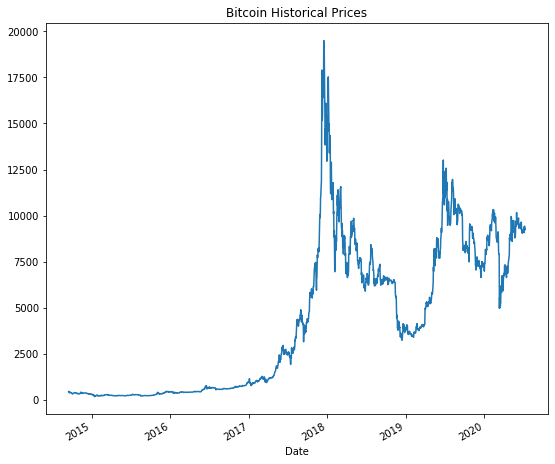

In [7]:
bitcoin = DataReader('BTC-USD', 'yahoo',start, end)
bitcoin.drop(columns=['High','Low','Open','Volume','Adj Close'], inplace=True)
bitcoin['Return'] = 100*(sp_price['Close'].pct_change())
bitcoin['Close'].plot()
plt.title('Bitcoin Historical Prices')
plt.show()

In [8]:
# Specify model assumptions
gjr_gm = arch_model(bitcoin['Return'].dropna(), p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Get model estimated volatility
gjrgm_vol = gjrgm_result.conditional_volatility

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1665.63
Distribution:      Standardized Student's t   AIC:                           3343.26
Method:                  Maximum Likelihood   BIC:                           3375.00
                                              No. Observations:                 1465
Date:                      Mon, Jul 13 2020   Df Residuals:                     1459
Time:                              08:32:30   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [9]:
# Specify model assumptions
egarch_gm = arch_model(bitcoin['Return'].dropna(), p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Get model estimated volatility
egarch_vol = egarch_result.conditional_volatility

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -1665.03
Distribution:      Standardized Student's t   AIC:                           3342.06
Method:                  Maximum Likelihood   BIC:                           3373.79
                                              No. Observations:                 1465
Date:                      Mon, Jul 13 2020   Df Residuals:                     1459
Time:                              08:32:30   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

## Compare GJR-GARCH with EGARCH

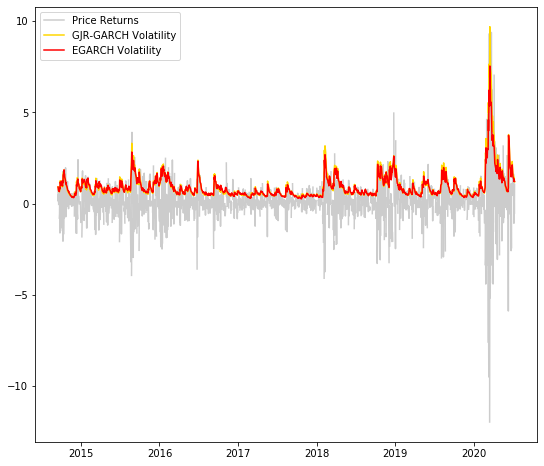

In [10]:
# Plot the actual Bitcoin returns
plt.plot(bitcoin['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'gold', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper left')

Overall both GJR-GARCH and EGARCH models did a good job of fitting the actual data. Comparatively, GJR-GARCH is more conservative in volatility estimation when applying it to the Bitcoin dataset.

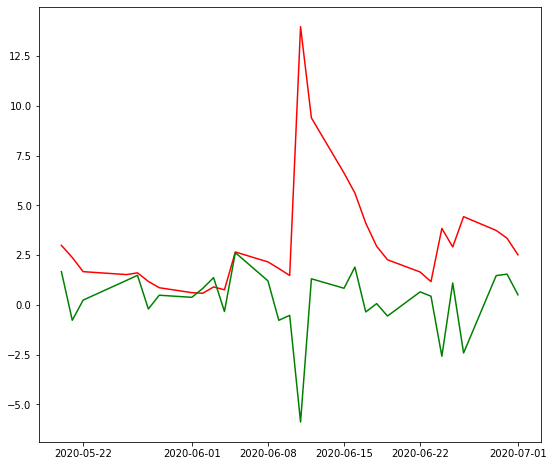

In [11]:
start_loc = 2491
end_loc = 2611
forecasts = {}
for i in range(30):
    # Specify fixed rolling window size for model fitting
    gm_result = basic_gm.fit(first_obs = i + start_loc, 
                             last_obs = i + end_loc, update_freq = 5, disp = 'off')
    # Conduct 1-period variance forecast and save the result
    temp_result = gm_result.forecast(horizon = 1).variance
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast
# Save all forecast to a dataframe    
forecast_var = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.plot(forecast_var, color = 'red')
plt.plot(sp_price.Return['2020-5-20':'2020-7-1'], color = 'green')
plt.show()

In [12]:
start_loc = 2491
end_loc = 2611
forecasts_expand = {}
forecasts_fixed = {}

for i in range(30):
    # Specify rolling window size for model fitting
    variance_expandwin_result = basic_gm.fit(first_obs = start_loc, 
                             last_obs = i + end_loc, update_freq = 5,disp = 'off')
    # Specify fixed rolling window size for model fitting
    variance_fixedwin_result = basic_gm.fit(first_obs = i + start_loc, 
                             last_obs = i + end_loc, update_freq = 5,disp = 'off')
    # Conduct 1-period variance forecast and save the result
    temp_result_expand = variance_expandwin_result.forecast(horizon = 1).variance
    temp_result_fixed = variance_fixedwin_result.forecast(horizon = 1).variance
    fcast_expand = temp_result_expand.iloc[i + end_loc]
    fcast_fixed = temp_result_fixed.iloc[i + end_loc]
    forecasts_expand[fcast_expand.name] = fcast_expand
    forecasts_fixed[fcast_fixed.name] = fcast_fixed
    
# Save all forecast to a dataframe    

forecast_var_expand = pd.DataFrame(forecasts_expand).T
forecast_var_fixed = pd.DataFrame(forecasts_fixed).T

                 h.1
2020-05-20  2.989854
2020-05-21  2.385468
2020-05-22  1.698573
2020-05-26  1.565437
2020-05-27  1.654065
                 h.1
2020-05-20  2.989854
2020-05-21  2.377146
2020-05-22  1.665437
2020-05-26  1.518299
2020-05-27  1.606014


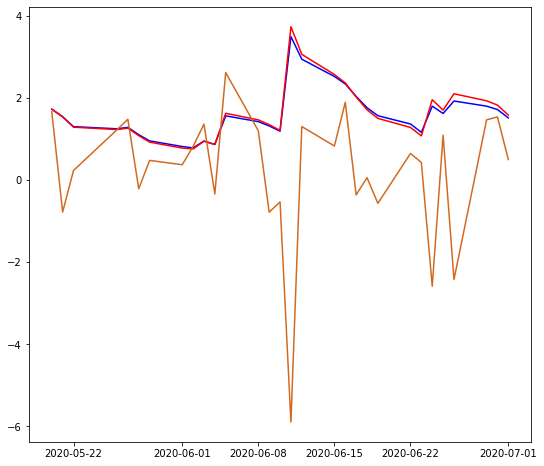

In [13]:
# Print header of variance forecasts with expanding and fixed window
print(forecast_var_expand.head())
print(forecast_var_fixed.head())

# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(forecast_var_expand)
# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(forecast_var_fixed)

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue')
# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red')
plt.plot(sp_price.Return['2020-5-20':'2020-7-1'], color = 'chocolate')
#plt.plot(bitcoin_data.Return['2019-4-1':'2019-9-15'], color = 'chocolate')
plt.show()

By comparison, volatility forecast with a fixed rolling window approach is more responsive to recent return shocks than forecast with an expanding window approach.